In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
from statistics import mean
import os
#

In [2]:

path_to_data = 'data/full'
individ_folders = sorted(os.listdir(path_to_data))

In [3]:
# Organise Samples
meta_testing_full_labels = np.load('data/meta_testing_full_labels.npy', allow_pickle=True).item()
full_list = os.listdir('data/full')

testing_list = [x[10:13] for x in meta_testing_full_labels['image']]
testing_list = sorted(list(set(testing_list)))

training_list = [y for y in full_list if y not in testing_list]
validation_list = testing_list[:-5]

In [41]:
# Organise Labels
all_labels = sorted(os.listdir(os.path.join(path_to_data, '001', 'labels')))
chosen_labels = ["LIST_A01_r.npy","LIST_A02_r.npy","LIST_F23_r.npy","LIST_F24_r.npy",
                  "LIST_A01_l.npy","LIST_A02_l.npy","LIST_F23_l.npy","LIST_F24_l.npy"]

def create_label_code(list_of_labels):
    d = {}
    for i, label in enumerate(list_of_labels):
        d[label] = i
    return d

def create_code_label(list_of_labels):
    d = {}
    for i, label in enumerate(list_of_labels):
        d[i] = label
    return d

label_code = create_label_code(chosen_labels)
code_label = create_code_label(chosen_labels)

def convert_label2code(label, label_code = label_code):
    code = label_code[label]
    return code

def convert_code2label(code, label_code=label_code):
    return next((key for key, val in label_code.items() if val == code), None)

In [42]:
if not os.path.isdir('datasets/yolo_segm_full_8lms/train/images'):
    os.makedirs('datasets/yolo_segm_full_8lms/train/images')
if not os.path.isdir('datasets/yolo_segm_full_8lms/val/images'):
    os.makedirs('datasets/yolo_segm_full_8lms/val/images')
if not os.path.isdir('datasets/yolo_segm_full_8lms/test/images'):
    os.makedirs('datasets/yolo_segm_full_8lms/test/images')

if not os.path.isdir('datasets/yolo_segm_full_8lms/train/labels'):
    os.makedirs('datasets/yolo_segm_full_8lms/train/labels')
if not os.path.isdir('datasets/yolo_segm_full_8lms/val/labels'):
    os.makedirs('datasets/yolo_segm_full_8lms/val/labels')
if not os.path.isdir('datasets/yolo_segm_full_8lms/test/labels'):
    os.makedirs('datasets/yolo_segm_full_8lms/test/labels')

In [43]:
from PIL import Image

def image_np2jpg(ind_id, input_path, output_folder):
    img_array = np.load(input_path)
    origImage =  img_array[img_array.files[0]]
    origImage = origImage*255/max(origImage.flatten())
    image = Image.fromarray(np.uint8(origImage)).convert('RGB')
    image.save(os.path.join(output_folder, f'{ind_id}.jpg'))
    return image 

In [44]:
import cv2

def binary_to_polygon(array):
    image = np.uint8(array)
    resized = cv2.resize(image, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)

    # Convert resized mask to binary image
    resized_binary = (resized > 0.5).astype(np.uint8) * 255
    contours, _ = cv2.findContours(resized_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create annotation for each contour
    for contour in contours:
        # bbox = cv2.boundingRect(contour)
        # area = cv2.contourArea(contour)
        polygon = contour.flatten().tolist()
        return polygon

In [45]:
def polygon_to_yolo_locations(array):
    map_size = array.shape
    polygon = binary_to_polygon(array)
    return [coord / map_size[0] if idx % 2 == 0 else coord / map_size[1]
            for idx, coord in enumerate(polygon)]

In [46]:
def binary_to_array(array):
    """Convert mask to YOLO locations."""
    non_zero_coords = np.argwhere(array == 1)
    map_size = array.shape
    locations = [(j / map_size[1], i / map_size[0]) for i, j in non_zero_coords]
    return [item for sublist in locations for item in sublist] 

In [4]:
import os
import numpy as np

# Synchronous file writing
def write_labels(labels_output_path, lines):
    os.makedirs(os.path.dirname(labels_output_path), exist_ok=True)
    with open(labels_output_path, 'w') as file:
        file.writelines(lines)

# Process a single instance
def process_instance(ind, path_to_data, output_folder, chosen_labels):
    try:
        # Convert image from .npz to .jpg and save it
        image_path = os.path.join(path_to_data, ind, 'image', f'{ind}.npz')
        image_output_folder = os.path.join(output_folder, 'images')
        image_np2jpg(ind, image_path, image_output_folder)

        # Prepare labels
        labels_output_path = os.path.join(output_folder, 'labels', f'{ind}.txt')
        lines = []
        for label in chosen_labels:
            mask_path = os.path.join(path_to_data, ind, 'labels', label)
            if os.path.exists(mask_path):
                label_map = np.load(mask_path)
                if isinstance(label_map, np.lib.npyio.NpzFile):
                    label_map = label_map[label_map.files[0]]  # Handle .npz
                label_map = np.uint8(label_map)

                locs = polygon_to_yolo_locations(label_map)
                #locs = binary_to_array(label_map)
                locs_to_text = ' '.join(map(str, locs))
                code = convert_label2code(label)
                lines.append(f'{code} {locs_to_text}\n')

        # Write the labels synchronously
        write_labels(labels_output_path, lines)
        return f'{ind}.jpg'

    except Exception as e:
        print(f"Error processing {ind}: {e}")
        return None

# Process all instances
def process_all(training, path_to_data, output_folder, chosen_labels):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    results = []
    for ind in training:
        result = process_instance(ind, path_to_data, output_folder, chosen_labels)
        if result:
            results.append(result)
    return results



In [48]:
train_output_folder = 'datasets/yolo_segm_full_8lms/train'
val_output_folder = 'datasets/yolo_segm_full_8lms/val'
test_output_folder = 'datasets/yolo_segm_full_8lms/test'

In [49]:
# Run the processing function
training_images_array = process_all(training_list, path_to_data, train_output_folder, chosen_labels)
print(training_images_array)

['082.jpg', '026.jpg', '024.jpg', '031.jpg', '043.jpg', '021.jpg', '010.jpg', '075.jpg', '035.jpg', '029.jpg', '048.jpg', '015.jpg', '022.jpg', '056.jpg', '019.jpg', '025.jpg', '081.jpg', '094.jpg', '011.jpg', '047.jpg', '040.jpg', '045.jpg', '007.jpg', '044.jpg', '016.jpg', '017.jpg', '002.jpg', '012.jpg', '020.jpg', '037.jpg', '061.jpg', '014.jpg', '032.jpg', '055.jpg', '030.jpg', '086.jpg', '028.jpg', '013.jpg', '042.jpg', '077.jpg', '084.jpg', '079.jpg', '034.jpg', '074.jpg', '053.jpg', '027.jpg', '058.jpg', '046.jpg', '003.jpg', '008.jpg', '067.jpg', '004.jpg', '092.jpg', '076.jpg', '005.jpg', '063.jpg', '071.jpg', '098.jpg', '065.jpg', '057.jpg', '085.jpg', '073.jpg', '006.jpg', '033.jpg', '051.jpg', '080.jpg', '052.jpg', '093.jpg', '039.jpg', '100.jpg', '087.jpg', '059.jpg', '089.jpg', '009.jpg', '054.jpg', '038.jpg', '066.jpg', '036.jpg', '070.jpg', '072.jpg']


In [50]:
# validation
val_images_array = process_all(validation_list, path_to_data, 'datasets/yolo_segm_full_8lms/val', chosen_labels)
print(val_images_array)


['001.jpg', '018.jpg', '023.jpg', '041.jpg', '049.jpg', '050.jpg', '060.jpg', '062.jpg', '064.jpg', '068.jpg', '069.jpg', '078.jpg', '083.jpg', '088.jpg', '090.jpg']


In [51]:
# testing
testing_images_array = process_all(testing_list, path_to_data, 'datasets/yolo_segm_full_8lms/test', chosen_labels)
print(testing_images_array)

['001.jpg', '018.jpg', '023.jpg', '041.jpg', '049.jpg', '050.jpg', '060.jpg', '062.jpg', '064.jpg', '068.jpg', '069.jpg', '078.jpg', '083.jpg', '088.jpg', '090.jpg', '091.jpg', '095.jpg', '096.jpg', '097.jpg', '099.jpg']


In [52]:
import yaml
yam = {}
yam['path'] = 'yolo_segm_full_8lms'
yam['train'] = 'train/images'
yam['val'] = 'val/images'
yam['names'] = code_label
with open('yolo_full_set_segm_8lms.yaml', 'w') as yaml_file:
    yaml.dump(yam, yaml_file, default_flow_style=False)

In [7]:
"""
This code defines a function to display an image with its corresponding annotations. 
It reads an image and its associated annotation file in the YOLO v8 text format, 
then plots the image along with colored polygons representing the annotated regions. 
The polygons are drawn according to the coordinates provided in the annotation file, 
and colors are assigned based on the category ID.

"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_image_with_annotations(image_path, annotation_path, colors=None):
    # Load image using OpenCV and convert it from BGR to RGB color space
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    
    # Create a figure and axis to display the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = plt.cm.get_cmap('rainbow')

    # Open the annotation file and process each line
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            category_id = int(parts[0])
            # Choose color based on category ID, looping through color map if more than 10 categories
            color = colors(category_id % 10)
            # Extract normalized polygon coordinates and denormalize them
            polygon = [float(coord) for coord in parts[1:]]
            polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
            # Reshape into (num_points, 2) array
            polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
            # Create a Polygon patch using the denormalized coordinates
            patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
            # Add the patch to the plot to display the annotated region
            ax.add_patch(patch)

    plt.show()  # Display the image with annotations



/tmp/ipykernel_836/546300634.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('rainbow')


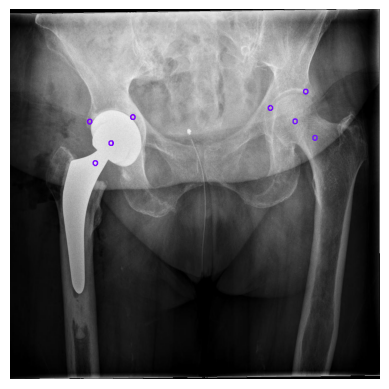

In [8]:
# Example usage with specified image and annotation paths
image_path = "datasets/yolo_segm_full_8lms/train/images/003.jpg"
annotation_path = "datasets/yolo_segm_full_8lms/train/labels/003.txt"
display_image_with_annotations(image_path, annotation_path)

In [56]:
# # load pretrained model
from ultralytics import YOLO
model = YOLO("yolo11s-seg.pt")


In [57]:
results = model.train(data="yolo_full_set_segm_8lms.yaml", project='runs_8_lm_segm_300', epochs=300, imgsz=640, degrees=10, hsv_v=0.3, fliplr=0.0, flipud=0.0, device=0, exist_ok=True)

New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=yolo_full_set_segm_8lms.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs_8_lm_segm_300, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

train: Scanning /home/katya/Huggingface/datasets/yolo_segm_full_8lms/train/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 375.63it/s]

train: New cache created: /home/katya/Huggingface/datasets/yolo_segm_full_8lms/train/labels.cache



val: Scanning /home/katya/Huggingface/datasets/yolo_segm_full_8lms/val/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 370.11it/s]

val: New cache created: /home/katya/Huggingface/datasets/yolo_segm_full_8lms/val/labels.cache


Plotting labels to runs_8_lm_segm_300/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs_8_lm_segm_300/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/300      5.07G      2.503      6.371      459.8     0.9481        155        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         15        120          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/300      5.08G      3.015      6.608      413.9      1.162        183        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         15        120          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/300      5.02G      1.939      5.806      456.5     0.6035        155        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         15        120          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/300      5.09G      4.944      5.964      231.1      1.539        173        640: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         15        120          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/300      5.14G       5.07      5.264      30.01      1.384        154        640: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         15        120          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/300      5.13G      4.402      5.056      10.97      1.136        180        640: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         15        120          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/300      5.15G      4.161      4.987      8.193      1.076        117        640: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         15        120      0.013     0.0583    0.00651    0.00135     0.0061     0.0167    0.00538    0.00128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/300      5.13G      3.916      4.617      6.646      1.039        160        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         15        120     0.0015     0.0667   0.000882   0.000191    0.00107     0.0583   0.000624   0.000238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/300      5.21G      3.947      4.898      5.925      1.009        189        640: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         15        120    0.00647      0.142    0.00411    0.00151    0.00526        0.1    0.00352   0.000609



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/300      5.11G      3.889      4.994      5.305     0.9763        129        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         15        120    0.00891      0.192    0.00917    0.00253      0.132     0.0333    0.00248   0.000439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/300      5.13G      3.909      4.747      4.621     0.9952        154        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         15        120      0.285     0.0917     0.0253     0.0065      0.414      0.075     0.0289    0.00362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/300      5.15G      3.745      4.562      4.339     0.9875        166        640: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         15        120     0.0203      0.233     0.0311    0.00803      0.168      0.117     0.0309    0.00637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/300      5.11G      3.703      5.014      3.914     0.9661        190        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         15        120     0.0357      0.142     0.0253     0.0051      0.163     0.0667     0.0145     0.0018



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/300      5.17G      3.891      4.968      4.204     0.9543        140        640: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         15        120     0.0305      0.122     0.0183    0.00505     0.0521      0.117     0.0273    0.00913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/300      5.14G      3.659      4.635      3.426     0.9706        162        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         15        120    0.00679      0.158    0.00712    0.00165    0.00437     0.0667    0.00252   0.000564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/300      5.11G       3.64      4.511      3.577     0.9737        165        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         15        120      0.536     0.0583      0.026    0.00775      0.402      0.075     0.0186    0.00468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/300      5.13G      3.591      4.793      3.435     0.9528        159        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         15        120      0.342     0.0522     0.0292    0.00965      0.147     0.0583    0.00944    0.00189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/300      5.13G      3.524      4.548      3.133     0.9463        147        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         15        120      0.167     0.0833     0.0223    0.00519      0.144     0.0417    0.00439   0.000611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/300      5.13G       3.59       4.65       3.11     0.9358        163        640: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         15        120      0.538     0.0568      0.015    0.00335      0.264     0.0417    0.00551    0.00059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/300      5.15G      3.471      4.437      2.907     0.9334        152        640: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         15        120       0.46      0.125     0.0409    0.00872      0.447      0.075      0.022    0.00243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/300      5.07G      3.503      4.478      2.795     0.9295        186        640: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         15        120      0.343      0.136     0.0531     0.0131      0.279     0.0745     0.0202    0.00414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/300      5.13G      3.468      4.307      2.844     0.9408        131        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         15        120       0.35     0.0985     0.0382    0.00806      0.333     0.0652     0.0219    0.00535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/300      5.15G       3.37      4.351      2.821     0.9489        152        640: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         15        120      0.212        0.1     0.0576     0.0104      0.193     0.0777     0.0371     0.0053



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/300      5.15G      3.371      4.204      2.591     0.9297        167        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         15        120       0.16     0.0667     0.0189    0.00268       0.15     0.0583     0.0182    0.00328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/300      5.11G       3.31      4.442      2.615     0.9353        152        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         15        120      0.204      0.106     0.0538     0.0088      0.171     0.0782     0.0291     0.0053



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/300      5.14G      3.566      4.252      2.522     0.9391        200        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         15        120      0.189     0.0917     0.0413    0.00635      0.329     0.0583      0.038    0.00738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/300      5.14G      3.426      4.164      2.501     0.9227        176        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         15        120      0.212        0.1     0.0589     0.0117      0.013      0.267     0.0281    0.00612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/300      5.13G      3.408      4.431       2.43     0.9133        171        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         15        120      0.194       0.11     0.0588     0.0121      0.171     0.0833      0.022    0.00304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/300      5.14G      3.396      4.138      2.554     0.9365        209        640: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15        120      0.186      0.267      0.147     0.0429      0.121      0.183      0.101     0.0342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/300      5.19G      3.413      4.423      2.582     0.9318        158        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         15        120      0.155      0.242      0.152     0.0342      0.147      0.244       0.13     0.0408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/300      5.16G      3.265      4.259      2.314     0.9318        203        640: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         15        120      0.129      0.302      0.166     0.0418      0.134      0.302      0.128     0.0443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/300      5.13G      3.428      4.206      2.332     0.9147        189        640: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15        120      0.177      0.283      0.167     0.0531      0.163      0.313      0.153     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/300      5.12G      3.353      3.795      2.263     0.9212        111        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15        120       0.18      0.311      0.179     0.0511      0.203      0.308      0.185     0.0486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/300      5.13G      3.384      4.187      2.326      0.917        188        640: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         15        120        0.2      0.303      0.165     0.0363      0.147      0.271      0.185     0.0608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/300      5.16G      3.361      4.029      2.308      0.916        128        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         15        120      0.138      0.295      0.161     0.0375      0.158        0.3       0.21     0.0646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/300      5.11G      3.093      3.884       2.21     0.9037        148        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         15        120      0.164      0.267      0.138     0.0384      0.256      0.383      0.229     0.0708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/300      5.19G      3.096      3.762      2.042     0.8987        153        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         15        120      0.306      0.336      0.222     0.0622      0.223      0.316      0.223      0.082



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/300      5.13G      3.267      4.005      2.175     0.8984        137        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         15        120      0.211      0.317      0.198     0.0583      0.143      0.261       0.18     0.0491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/300      5.16G      3.199      4.102      2.182     0.9022        167        640: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         15        120      0.246        0.4      0.226     0.0692       0.22      0.392      0.209     0.0849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/300      5.13G      3.225      3.845      2.169     0.9063        144        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         15        120      0.264      0.309      0.237     0.0729      0.191      0.275      0.172     0.0547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/300      5.12G      3.063      3.761      2.178     0.8977        142        640: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         15        120      0.202      0.284      0.142     0.0475      0.125      0.242       0.11      0.026



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/300      5.14G      3.011      3.889      2.067     0.8735        194        640: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         15        120      0.239      0.333       0.18     0.0543      0.165      0.289      0.128     0.0271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/300      5.12G      2.953      3.804      2.042     0.8965        153        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         15        120      0.255      0.383      0.217      0.065      0.178      0.355      0.163     0.0577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/300      5.12G      3.068      3.778      2.059     0.8967        147        640: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15        120      0.269      0.309      0.212     0.0534      0.348      0.208      0.167     0.0468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/300      5.19G      3.135      3.859      2.082     0.8889        239        640: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15        120      0.361      0.287      0.197     0.0451      0.307      0.131      0.111     0.0264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/300      5.16G      2.867      3.541      1.934     0.8947        173        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         15        120      0.211      0.309      0.182     0.0454      0.153      0.217      0.128     0.0275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/300      5.15G      3.012      3.875      1.993     0.8904        160        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         15        120      0.161      0.248      0.137     0.0442      0.158       0.23      0.145     0.0343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/300      5.16G      3.128      3.799      2.058     0.9048        190        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         15        120      0.155      0.224      0.135     0.0366      0.131      0.167      0.115     0.0199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/300      5.12G      3.097      3.768      2.013     0.8743        147        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15        120      0.258      0.225      0.135     0.0394      0.154      0.217      0.165     0.0286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/300      5.16G      3.111      3.571       1.93     0.8852        194        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15        120      0.132      0.292      0.179     0.0551      0.129      0.283      0.183       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/300      5.14G      2.924      3.661      1.913     0.8813        148        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         15        120      0.325      0.308      0.197     0.0532      0.275      0.345      0.192     0.0588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/300      5.14G      3.009      3.654      1.981     0.8723        118        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         15        120       0.18       0.29      0.172     0.0518      0.102      0.192      0.112     0.0252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/300      5.19G      2.926      3.598      1.973     0.8728        172        640: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         15        120      0.182      0.292      0.129     0.0367      0.128      0.198      0.106      0.022



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/300      5.16G      2.911      3.786      1.818     0.8848        143        640: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         15        120      0.194      0.292      0.151     0.0408      0.137      0.183      0.115     0.0272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/300      5.21G      2.915      3.566      1.917     0.8743        151        640: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         15        120        0.2      0.294      0.181      0.058      0.181      0.333      0.168     0.0422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/300      5.21G      2.986      3.795      1.926     0.8746        197        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         15        120      0.193      0.292      0.175     0.0502      0.187      0.286      0.158     0.0372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/300      5.11G       2.83      3.786      1.884     0.8707        124        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         15        120       0.19      0.306      0.198     0.0486      0.204      0.345       0.19     0.0457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/300      5.16G      3.067      3.767      1.882     0.8845        176        640: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         15        120      0.209      0.306      0.193     0.0547       0.17      0.288      0.168     0.0583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/300      5.13G      3.182      4.025      1.867     0.8965        143        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         15        120      0.206      0.324      0.192     0.0524      0.164      0.264      0.151     0.0462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/300      5.13G      3.058       3.83      1.899     0.8738        174        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         15        120      0.199      0.333      0.184     0.0546      0.198      0.342      0.167     0.0458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/300      5.12G      2.912      3.617      1.808     0.8764        207        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         15        120      0.218      0.293      0.205     0.0698      0.177      0.327      0.196      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/300       5.2G      2.886      3.745       1.77     0.8691        196        640: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15        120      0.191      0.367      0.205     0.0602      0.154      0.325      0.188      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/300      5.12G      2.872       3.59      1.708     0.8766        162        640: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        120      0.211      0.365      0.186     0.0571      0.167      0.361      0.191     0.0704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/300      5.14G      2.889      3.455      1.716     0.8658        142        640: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         15        120      0.306      0.282      0.252     0.0599       0.18      0.213      0.174     0.0588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/300      5.12G        2.8      3.521      1.784     0.8495        129        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         15        120      0.242      0.278      0.203       0.06      0.149      0.242      0.125     0.0274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/300      5.18G      2.859      3.464      1.804     0.8848        206        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15        120      0.249      0.292      0.197     0.0552       0.19      0.258      0.161     0.0426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/300      5.13G      2.872      3.654      1.746     0.8777        166        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         15        120      0.232      0.328      0.221     0.0668       0.18      0.285      0.159     0.0425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/300      5.19G      2.771      3.649      1.767     0.8689        137        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         15        120      0.228      0.311      0.218     0.0656      0.151      0.258      0.116     0.0274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/300      5.19G      2.755      3.634      1.693     0.8665        145        640: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15        120      0.232      0.313      0.234     0.0703      0.126      0.263      0.138     0.0488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/300      5.16G       2.84      3.532      1.798      0.869        103        640: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         15        120       0.27      0.346      0.248     0.0791      0.165      0.296      0.192      0.053



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/300      5.14G      2.831      3.489       1.68     0.8778        130        640: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         15        120      0.228      0.358      0.232     0.0655      0.236      0.419       0.26      0.085



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/300      5.13G      2.909      3.536      1.725     0.8734        166        640: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         15        120      0.217       0.35      0.205      0.063       0.17       0.35      0.177     0.0483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/300      5.13G      2.734      3.354      1.796     0.8714        142        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         15        120        0.2      0.357      0.202     0.0629      0.171      0.368      0.156     0.0408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/300      5.15G      2.838      3.491      1.693      0.866        178        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15        120       0.23      0.433      0.236     0.0715      0.164      0.358      0.161     0.0513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/300      5.14G      2.855      3.595      1.652     0.8583        163        640: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15        120      0.222       0.42      0.232     0.0668      0.197      0.425      0.212     0.0596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/300      5.15G      2.742       3.63       1.71     0.8536        116        640: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15        120      0.209      0.362      0.196     0.0412      0.184      0.342      0.165     0.0378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/300       5.2G       2.76      3.392      1.599      0.859        135        640: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         15        120      0.176      0.272      0.158     0.0397      0.171      0.283      0.157     0.0394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/300       5.2G      2.917      3.552       1.73     0.8744        163        640: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         15        120      0.177      0.283      0.152     0.0385      0.182       0.34      0.185     0.0463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/300      5.14G      2.721      3.227      1.606     0.8528        165        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, -1.03it/s]

                   all         15        120      0.166      0.267      0.172     0.0436      0.171       0.25      0.165     0.0402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/300      5.14G      2.729       3.35      1.597     0.8639        201        640: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         15        120      0.277      0.275      0.194     0.0415      0.109      0.196     0.0807     0.0152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/300      5.18G      2.933      3.683      1.678     0.8596        168        640: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         15        120      0.265      0.309      0.218     0.0472      0.104      0.217     0.0902     0.0201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/300      5.14G      2.768       3.53      1.652     0.8604        176        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         15        120      0.272      0.349      0.242     0.0628      0.125      0.275      0.112     0.0237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/300      5.13G      2.793      3.401      1.631     0.8714        149        640: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         15        120      0.311      0.306      0.232     0.0649      0.179      0.324      0.167     0.0411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/300      5.21G      2.794      3.569      1.682     0.8632        180        640: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         15        120      0.256      0.331      0.231     0.0573      0.123      0.255        0.1     0.0272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/300      5.12G      2.782      3.452      1.643     0.8617        149        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         15        120      0.228      0.358      0.234     0.0619      0.155      0.281      0.127     0.0354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/300      5.14G       2.78      3.298      1.685     0.8575        180        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15        120       0.27      0.383      0.291     0.0789      0.197      0.326      0.191     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/300      5.13G      2.828      3.372       1.62     0.8607        173        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         15        120      0.354      0.314      0.273     0.0773      0.232      0.325      0.229     0.0718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/300      5.15G      2.752      3.238      1.596     0.8542        188        640: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         15        120      0.208        0.4      0.244     0.0723      0.226      0.409      0.275     0.0794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/300      5.12G      2.679      3.289      1.626     0.8604        122        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15        120      0.214      0.317       0.23     0.0677      0.183      0.425      0.223     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/300      5.21G      2.658      3.274      1.561     0.8488        192        640: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         15        120      0.211      0.389      0.221     0.0702      0.146      0.373      0.154     0.0392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/300      5.16G      2.673      3.066       1.53     0.8492        179        640: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         15        120      0.221      0.353      0.252     0.0827      0.159      0.362      0.162     0.0486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/300      5.16G      2.655      3.221      1.613     0.8584        131        640: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         15        120      0.276      0.433      0.305      0.096       0.23      0.366      0.241      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/300      5.15G      2.781      3.319      1.574     0.8582        126        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         15        120      0.251      0.421      0.271     0.0888       0.22      0.442       0.25     0.0832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/300      5.15G      2.674      3.315       1.59     0.8666        230        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15        120      0.213      0.412      0.221     0.0644      0.161      0.304      0.136     0.0438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/300      5.15G      2.784      3.562      1.628     0.8582        190        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         15        120      0.173      0.376      0.203       0.06      0.151       0.25      0.116     0.0366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/300      5.17G      2.694      3.221      1.565     0.8599        188        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         15        120      0.257      0.346      0.277     0.0645      0.187      0.283      0.183     0.0451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/300      5.11G      2.672      3.604      1.659     0.8583        157        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         15        120      0.211      0.417      0.254     0.0698      0.213      0.365      0.203     0.0481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/300      5.14G      2.795      3.473      1.671     0.8662        182        640: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         15        120      0.242      0.333       0.26     0.0788      0.152      0.335       0.15     0.0374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/300      5.14G      2.747       3.49      1.654     0.8621        125        640: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         15        120      0.328      0.272      0.239     0.0679      0.134       0.29      0.122     0.0308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/300      5.15G      2.579      3.366      1.503     0.8413        124        640: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         15        120      0.267      0.348      0.247     0.0568      0.187      0.365      0.168     0.0357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/300      5.11G      2.627      3.233       1.42     0.8554        222        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         15        120      0.283      0.328      0.246     0.0627      0.163      0.317       0.15     0.0317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/300      5.13G      2.563      3.045      1.419     0.8448        175        640: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15        120      0.308      0.317      0.271     0.0715      0.137      0.283      0.161      0.042



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/300      5.14G      2.685      3.379       1.47     0.8335        199        640: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15        120      0.311      0.315      0.264     0.0723      0.103      0.222      0.112     0.0363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/300      5.16G      2.541      3.295       1.46     0.8447        176        640: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         15        120      0.272      0.317      0.242     0.0685      0.156       0.26       0.18     0.0615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/300      5.12G      2.593      3.354      1.514     0.8532        124        640: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         15        120       0.27      0.347      0.265     0.0808      0.207      0.272      0.189     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/300      5.14G      2.657      3.079      1.557     0.8533        118        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         15        120       0.26      0.339      0.276     0.0702      0.208      0.292      0.179     0.0579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/300      5.14G      2.588       3.27      1.485     0.8677        145        640: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         15        120      0.246      0.342      0.234     0.0585      0.175      0.233      0.155     0.0395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/300      5.14G      2.652      3.297      1.479     0.8456        132        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15        120      0.257      0.375       0.26     0.0759      0.202      0.306      0.186     0.0478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/300      5.11G      2.598      3.287       1.46     0.8454        178        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         15        120      0.296      0.411      0.283     0.0846      0.221      0.392      0.232     0.0692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/300      5.13G      2.659      3.101       1.47     0.8495        214        640: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         15        120      0.321      0.359      0.277     0.0852      0.229      0.333      0.231     0.0846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/300      5.13G      2.504      3.132      1.441     0.8517        149        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         15        120      0.339      0.387      0.286     0.0838      0.212      0.296      0.207     0.0766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/300      5.13G      2.518      3.198      1.398     0.8391        163        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15        120      0.242      0.367      0.257     0.0732      0.227      0.288      0.197     0.0438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/300      5.11G      2.629      3.073      1.532     0.8459        124        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15        120      0.277      0.358      0.285     0.0867      0.199      0.258      0.177     0.0475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/300      5.13G      2.455      3.206      1.433     0.8445        172        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         15        120      0.257      0.342      0.268      0.082      0.364      0.257       0.22     0.0573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/300      5.13G      2.511      2.918      1.427     0.8681        113        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15        120        0.3      0.374      0.278     0.0806      0.232      0.275      0.189     0.0473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/300      5.16G      2.628      3.024       1.43     0.8574        170        640: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         15        120       0.22      0.359      0.226     0.0619      0.139      0.258      0.136     0.0344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/300      5.15G      2.581      3.098       1.46     0.8572        188        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15        120      0.207      0.328      0.204     0.0571      0.107        0.2     0.0924     0.0222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/300      5.15G      2.515      3.095      1.446     0.8439        209        640: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         15        120      0.231      0.337      0.206     0.0563      0.107      0.183     0.0929     0.0241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/300      5.13G       2.51      3.109      1.493     0.8352        169        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         15        120      0.196      0.274      0.173     0.0508      0.098      0.192     0.0948     0.0221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/300      5.11G      2.567       3.13      1.492     0.8417        205        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         15        120      0.208      0.263      0.195     0.0516      0.165      0.333      0.174     0.0347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/300      5.12G      2.508      3.077      1.392     0.8379        147        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         15        120      0.268      0.308      0.233     0.0574      0.162      0.267      0.149     0.0369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/300      5.13G      2.597      3.367      1.475     0.8355        144        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         15        120      0.202        0.3      0.191     0.0519      0.156      0.242      0.146     0.0377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/300      5.15G      2.551      3.038      1.448     0.8358        151        640: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15        120      0.237      0.242      0.199     0.0525      0.122      0.219       0.12     0.0285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/300      5.14G      2.617      3.134      1.449       0.85        187        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         15        120      0.292      0.225      0.206     0.0571      0.143      0.267      0.121     0.0286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/300      5.14G      2.487      3.068      1.369     0.8466        137        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         15        120      0.318      0.275       0.24     0.0678      0.195      0.172      0.127     0.0347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/300      5.15G       2.52      3.147      1.417     0.8508        131        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         15        120      0.303      0.284      0.229     0.0665      0.132      0.222      0.104     0.0259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/300      5.15G      2.596      3.004      1.407     0.8472        186        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         15        120       0.27      0.266      0.201     0.0575      0.143      0.177      0.116     0.0279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/300      5.21G      2.535      3.206      1.367     0.8475        185        640: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         15        120      0.279      0.225      0.193     0.0568      0.137      0.192      0.108     0.0173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/300      5.11G      2.492      3.149      1.355     0.8397        152        640: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         15        120      0.285      0.284      0.253     0.0766      0.187      0.217      0.149     0.0448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/300      5.13G       2.43      2.775      1.359     0.8366        113        640: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         15        120      0.299      0.284       0.28     0.0939      0.166      0.267      0.165     0.0469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/300      5.13G      2.489       2.96      1.397     0.8209        177        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         15        120      0.326      0.328      0.297     0.0932      0.203      0.313      0.207     0.0542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/300      5.12G      2.356      2.867      1.353     0.8419        142        640: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         15        120        0.3       0.36      0.304      0.099      0.166        0.3      0.162     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/300      5.12G      2.361      2.843      1.293     0.8347        158        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         15        120      0.304      0.367        0.3      0.102      0.192      0.292      0.165     0.0496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/300      5.14G      2.419      3.013      1.331     0.8461        126        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         15        120      0.382       0.37      0.317      0.103       0.21      0.292      0.184       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/300      5.16G      2.487      2.843      1.396     0.8293        192        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         15        120      0.311       0.38      0.329      0.101        0.3      0.208       0.21     0.0704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/300      5.19G      2.441      2.909      1.297     0.8327        138        640: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, -1.24it/s]

                   all         15        120      0.278      0.314      0.249     0.0768       0.21      0.267      0.191     0.0512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/300      5.11G      2.432      3.182      1.366     0.8303        177        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         15        120      0.292      0.352       0.28     0.0884       0.16      0.274      0.165     0.0463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/300      5.17G      2.354      2.834      1.295      0.826        184        640: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         15        120      0.302      0.356      0.288     0.0887      0.172      0.291      0.166     0.0461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/300      5.14G      2.313      2.695      1.257     0.8321        127        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         15        120      0.279      0.443      0.304     0.0963      0.206      0.361      0.211     0.0597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/300      5.14G      2.601      3.041      1.352     0.8281        143        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         15        120      0.256      0.415      0.301      0.105      0.205      0.383      0.196     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/300      5.14G      2.355      2.884      1.277     0.8325        128        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         15        120      0.309       0.36      0.317        0.1      0.176       0.34      0.182     0.0561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/300      5.13G      2.386      2.822      1.313     0.8344        194        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         15        120      0.332      0.375      0.348     0.0984      0.198      0.335      0.206      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/300      5.13G      2.252      2.896       1.27     0.8284        215        640: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         15        120      0.315      0.417      0.366      0.116      0.237      0.406       0.24     0.0711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/300      5.13G      2.306      2.888      1.343     0.8311        158        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15        120      0.299      0.455      0.365      0.105      0.226      0.342      0.214     0.0671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/300      5.18G      2.312      2.773      1.298     0.8194        184        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         15        120      0.242      0.432       0.29     0.0907      0.199      0.341       0.19     0.0429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/300      5.14G        2.4      2.852      1.309     0.8348        176        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15        120      0.245      0.405      0.273     0.0838      0.182      0.357      0.178     0.0366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/300      5.12G      2.368      2.572      1.296     0.8256        186        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15        120      0.288      0.375       0.31      0.096      0.198      0.325      0.182     0.0388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/300      5.13G      2.465      2.854      1.254     0.8357        152        640: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        120      0.383      0.322      0.339      0.115      0.188      0.284      0.167     0.0375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/300      5.12G      2.327       2.77      1.275     0.8228        183        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15        120      0.294      0.326      0.319      0.105      0.203      0.336      0.192     0.0606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/300      5.15G      2.522      2.861      1.355     0.8363        179        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         15        120      0.487      0.315      0.316     0.0999      0.223      0.352      0.218     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/300      5.12G      2.449      2.971      1.352     0.8387        114        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         15        120      0.465      0.315      0.317      0.107      0.234      0.317      0.236     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/300      5.16G      2.321      2.838      1.269     0.8331        145        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15        120      0.311      0.342      0.303      0.113      0.234      0.249      0.202     0.0458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/300      5.11G      2.319      2.857      1.297     0.8235        175        640: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         15        120      0.234       0.44      0.292      0.103      0.217      0.265      0.198     0.0489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/300      5.15G      2.336      2.608      1.244      0.828        186        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         15        120      0.358      0.331      0.316     0.0998      0.197      0.361      0.201      0.053



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/300      5.15G      2.254      2.838      1.234     0.8271        172        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15        120      0.294      0.433      0.309        0.1      0.207       0.31      0.194     0.0459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/300      5.15G      2.308      2.488      1.326     0.8381        141        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15        120      0.243      0.383      0.276     0.0836      0.175       0.25      0.155     0.0472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/300      5.13G      2.346      2.999      1.271     0.8355        135        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         15        120      0.264      0.343      0.307     0.0918      0.187      0.261      0.178     0.0478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/300      5.13G      2.326      2.682      1.311     0.8232        192        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         15        120      0.241      0.421      0.322      0.104      0.152        0.3      0.179     0.0511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/300      5.13G      2.343      2.788      1.228     0.8313        134        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         15        120      0.241      0.448      0.297     0.0954      0.137      0.267      0.155     0.0458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/300      5.13G      2.187      2.714      1.264     0.8289        121        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         15        120      0.381      0.271       0.29     0.0917      0.218      0.208      0.167     0.0445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/300      5.12G      2.342      2.646      1.252     0.8283        188        640: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         15        120      0.373      0.267      0.295     0.0888      0.231      0.205      0.187      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/300      5.12G      2.279      2.731      1.206     0.8313        158        640: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15        120      0.272      0.423      0.311      0.103      0.229        0.2      0.182     0.0446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/300      5.14G      2.268       2.71      1.248     0.8336        143        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         15        120      0.255      0.319      0.253     0.0887      0.189      0.244      0.187     0.0427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/300      5.15G      2.344      2.724      1.258     0.8244        139        640: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         15        120      0.288      0.331      0.291     0.0926       0.17        0.3       0.18     0.0487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/300      5.14G      2.245      2.787       1.23     0.8318        200        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         15        120      0.287      0.312      0.277        0.1      0.184      0.305      0.181     0.0408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/300      5.14G      2.383      2.872      1.217     0.8242        190        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         15        120      0.266      0.325      0.251     0.0931      0.168      0.275      0.171     0.0359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/300      5.22G      2.261      2.903      1.282     0.8206        165        640: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, -1.28it/s]

                   all         15        120      0.291      0.317      0.251     0.0898      0.171       0.28      0.188     0.0384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/300      5.13G      2.191      2.598      1.265      0.822        194        640: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         15        120      0.332      0.325      0.275      0.105      0.207       0.27        0.2     0.0489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/300      5.13G      2.209      2.597      1.139     0.8371        151        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         15        120      0.323      0.375      0.309     0.0995      0.232      0.304      0.226     0.0605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/300      5.13G      2.189       2.44        1.2     0.8365        136        640: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15        120      0.349      0.358      0.315      0.103      0.212      0.336      0.209     0.0546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/300      5.15G      2.232      2.701      1.137     0.8276        146        640: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15        120      0.333      0.346      0.298      0.103      0.202      0.342      0.206     0.0554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/300      5.15G        2.2       2.63      1.141     0.8245        121        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         15        120      0.234      0.379      0.269     0.0942      0.186      0.321      0.198     0.0538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/300       5.2G      2.176      2.597      1.172     0.8298        190        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, -1.22it/s]

                   all         15        120       0.33      0.335      0.298      0.102      0.302      0.208      0.198     0.0525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/300      5.14G      2.181      2.562        1.2     0.8279        104        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         15        120      0.321      0.312      0.271     0.0966      0.238      0.215      0.181      0.049



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/300      5.14G      2.118      2.368      1.119     0.8288        186        640: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         15        120      0.275      0.337      0.263     0.0936      0.192       0.25      0.181     0.0471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/300      5.21G      2.241      2.482      1.156     0.8199        188        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         15        120      0.263      0.367      0.274     0.0899      0.179      0.267      0.155      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/300      5.11G       2.25      2.582      1.183     0.8206        182        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         15        120      0.273      0.323      0.269     0.0936      0.208      0.325      0.182     0.0504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/300      5.19G      2.227      2.554       1.14     0.8255        192        640: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         15        120      0.286      0.348      0.301      0.108      0.223      0.332      0.185     0.0518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/300       5.2G      2.255      2.547      1.167     0.8281        147        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         15        120      0.295      0.375      0.299      0.103      0.219      0.296      0.182      0.057



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/300      5.13G      2.175      2.677      1.123     0.8346        145        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        120      0.312        0.3      0.265     0.0899      0.173      0.279      0.166     0.0434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/300       5.2G      2.196      2.477      1.134     0.8173        158        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         15        120      0.289      0.342      0.276      0.101      0.193       0.26      0.188     0.0542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/300      5.13G      2.195      2.721      1.141     0.8219        119        640: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15        120        0.3      0.356      0.291     0.0949      0.216      0.267      0.189      0.056



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/300      5.19G      2.289      2.808      1.222     0.8178        154        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         15        120      0.257      0.403      0.288     0.0945      0.204      0.277      0.189     0.0519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/300      5.15G      2.258      2.584       1.13     0.8278        149        640: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         15        120      0.412        0.3      0.306     0.0888       0.25      0.175      0.181     0.0512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/300      5.12G      2.303      2.709      1.197     0.8382        169        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         15        120      0.354      0.292      0.295     0.0907      0.151      0.267      0.149     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/300      5.21G      2.253      2.484      1.155      0.822        150        640: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         15        120      0.399       0.28      0.312      0.103      0.149      0.266      0.159     0.0405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/300      5.14G      2.092      2.494      1.043      0.821        186        640: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15        120      0.234      0.438      0.299      0.105      0.287      0.258      0.246       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/300      5.14G      2.067      2.504      1.056     0.8143        112        640: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        120      0.288      0.313      0.264     0.0962      0.183      0.367      0.188     0.0384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/300      5.12G      2.178      2.536       1.12     0.8158        140        640: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        120      0.377      0.315      0.319      0.103       0.16      0.313      0.165     0.0356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/300      5.14G      2.163      2.271      1.149     0.8166        144        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15        120       0.28      0.315      0.272     0.0956      0.159      0.306      0.173     0.0385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/300      5.12G      2.206      2.465      1.065     0.8302        156        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         15        120      0.285      0.333      0.304     0.0953      0.178      0.344      0.177     0.0381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/300      5.15G      2.116      2.592      1.084     0.8276        169        640: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         15        120       0.29      0.329      0.297      0.101      0.191      0.308      0.224     0.0566
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 92, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



192 epochs completed in 0.558 hours.
Optimizer stripped from runs_8_lm_segm_300/train/weights/last.pt, 20.5MB
Optimizer stripped from runs_8_lm_segm_300/train/weights/best.pt, 20.5MB

Validating runs_8_lm_segm_300/train/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,912 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


                   all         15        120      0.278      0.433      0.304     0.0952      0.228      0.362      0.241      0.103
        LIST_A01_r.npy         15         15      0.422      0.467      0.415      0.112      0.299      0.333      0.336     0.0853
        LIST_A02_r.npy         15         15      0.428      0.733      0.678      0.237      0.386      0.667      0.527      0.322
        LIST_F23_r.npy         15         15      0.289      0.533      0.224     0.0691      0.249      0.467      0.197     0.0955
        LIST_F24_r.npy         15         15      0.247        0.4      0.183     0.0446      0.283      0.467      0.259      0.109
        LIST_A01_l.npy         15         15      0.332      0.533      0.413      0.118     0.0815      0.133     0.0756     0.0247
        LIST_A02_l.npy         15         15      0.241        0.4      0.189     0.0902      0.174      0.296       0.12     0.0395
        LIST_F23_l.npy         15         15      0.266        0.4   

# predict

In [4]:
images = os.listdir('datasets/yolo_segm_full_8lms/test/images')

In [6]:
# # load pretrained model
from ultralytics import YOLO
model = YOLO("runs_8_lm_segm_300/train/weights/best.pt")
model.val()

Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,912 parameters, 0 gradients, 35.3 GFLOPs


val: Scanning /home/katya/Huggingface/datasets/yolo_segm_full_8lms/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


                   all         15        120      0.279      0.433      0.291     0.0912      0.229       0.35      0.227     0.0933
        LIST_A01_r.npy         15         15      0.419      0.467      0.424      0.105      0.238      0.267      0.248     0.0585
        LIST_A02_r.npy         15         15       0.46      0.733      0.683      0.245      0.324      0.533      0.412      0.263
        LIST_F23_r.npy         15         15      0.285      0.533      0.223      0.069      0.283      0.533      0.248      0.101
        LIST_F24_r.npy         15         15      0.243        0.4      0.182      0.044      0.241        0.4      0.221     0.0873
        LIST_A01_l.npy         15         15      0.286      0.467      0.292     0.0903     0.0809      0.133     0.0756     0.0247
        LIST_A02_l.npy         15         15      0.277      0.467      0.193     0.0934      0.188      0.333      0.123     0.0406
        LIST_F23_l.npy         15         15      0.263        0.4   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7faca7750730>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0

In [7]:
all_results = {}
for image in images:
    result = model(f'datasets/yolo_segm_full_8lms/test/images/{image}', project='runs_8_lm_segm_300')
    name = image[:-4]
    all_results[name] = result[0]


image 1/1 /home/katya/Huggingface/datasets/yolo_segm_full_8lms/test/images/083.jpg: 640x640 1 LIST_A01_r.npy, 2 LIST_A02_r.npys, 1 LIST_F23_r.npy, 1 LIST_F24_r.npy, 1 LIST_A01_l.npy, 2 LIST_A02_l.npys, 1 LIST_F23_l.npy, 133.6ms
Speed: 5.4ms preprocess, 133.6ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/katya/Huggingface/datasets/yolo_segm_full_8lms/test/images/001.jpg: 640x640 2 LIST_A02_r.npys, 2 LIST_F23_r.npys, 1 LIST_F24_r.npy, 1 LIST_A01_l.npy, 19.6ms
Speed: 1.9ms preprocess, 19.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/katya/Huggingface/datasets/yolo_segm_full_8lms/test/images/062.jpg: 640x640 1 LIST_A01_r.npy, 1 LIST_A02_r.npy, 2 LIST_F23_r.npys, 1 LIST_F24_r.npy, 2 LIST_A01_l.npys, 1 LIST_A02_l.npy, 1 LIST_F23_l.npy, 19.8ms
Speed: 2.0ms preprocess, 19.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/katya/Huggingface/datasets/yolo_segm_full_8lms/test/images/

In [8]:
import yaml

with open('yolo_full_set_segm_8lms.yaml') as file:
    yaml_file = yaml.safe_load(file)
label_code = yaml_file['names']
def convert_code2label(code, label_code=label_code):
    return next((val for key, val in label_code.items() if key == code), None)

In [9]:
len(label_code)

8

In [10]:
import pandas as pd

def collect_class_accuracy(individ_summary):
    df = pd.DataFrame(individ_summary)
    df = df.set_index('name')
    classes = [int(x) for x in df['class'].to_list()]
    res = {}
    for c in range(len(label_code)):
        if c in classes:
            res[c] = df.loc[df['class']==c, 'confidence'].to_numpy()[0]
        else: res[c] = 0
    return res

stats = []
for key, result in all_results.items():
    summary = result.summary()
    class_accuracies = collect_class_accuracy(summary)
    class_accuracies['mean'] = (sum([float(x) for x in list(class_accuracies.values())]))/len(class_accuracies.keys())
    class_accuracies['name'] = key   
    stats.append(class_accuracies)

df = pd.DataFrame(stats)
df = df.set_index('name')

In [11]:
colnames = [convert_code2label(col) for col in df.columns]
df.columns = colnames
df

,LIST_A01_r.npy,LIST_A02_r.npy,LIST_F23_r.npy,LIST_F24_r.npy,LIST_A01_l.npy,LIST_A02_l.npy,LIST_F23_l.npy,LIST_F24_l.npy,None
name,,,,,,,,,
083,0.31109,0.45437,0.30420,0.31388,0.35569,0.31678,0.30466,0,0.295084
001,0.00000,0.29188,0.63009,0.31437,0.51479,0.00000,0.00000,0,0.218891
062,0.32443,0.44287,0.40925,0.27880,0.26601,0.45350,0.25806,0,0.304115
068,0.47041,0.54817,0.37247,0.00000,0.32147,0.59219,0.51319,0,0.352237
069,0.00000,0.46317,0.47391,0.39210,0.28437,0.66439,0.33115,0,0.326136
060,0.26249,0.45141,0.29812,0.00000,0.00000,0.48102,0.34803,0,0.230134
049,0.32396,0.45967,0.28091,0.29390,0.31323,0.41874,0.29994,0,0.298794
064,0.31186,0.41385,0.61463,0.33764,0.29872,0.34311,0.28875,0,0.326070
050,0.00000,0.53125,0.00000,0.29833,0.29651,0.44480,0.00000,0,0.196361


In [12]:
df.to_csv('runs_8_lm_segm_300/segment/val/testing_accuracy.csv')

In [68]:
for col in df.columns:
    print(col, df[col].mean())

LIST_A01_r.npy 0.16302049999999998
LIST_A02_r.npy 0.4309425
LIST_F23_r.npy 0.3308325
LIST_F24_r.npy 0.262956
LIST_A01_l.npy 0.281058
LIST_A02_l.npy 0.4223510000000001
LIST_F23_l.npy 0.272857
LIST_F24_l.npy 0.0
None 0.27050218750000005



image 1/1 /home/katya/Huggingface/datasets/yolo_segm_full_8lms/test/images/083.jpg: 640x640 1 LIST_A01_r.npy, 2 LIST_A02_r.npys, 1 LIST_F23_r.npy, 1 LIST_F24_r.npy, 1 LIST_A01_l.npy, 2 LIST_A02_l.npys, 1 LIST_F23_l.npy, 219.0ms
Speed: 8.3ms preprocess, 219.0ms inference, 121.8ms postprocess per image at shape (1, 3, 640, 640)


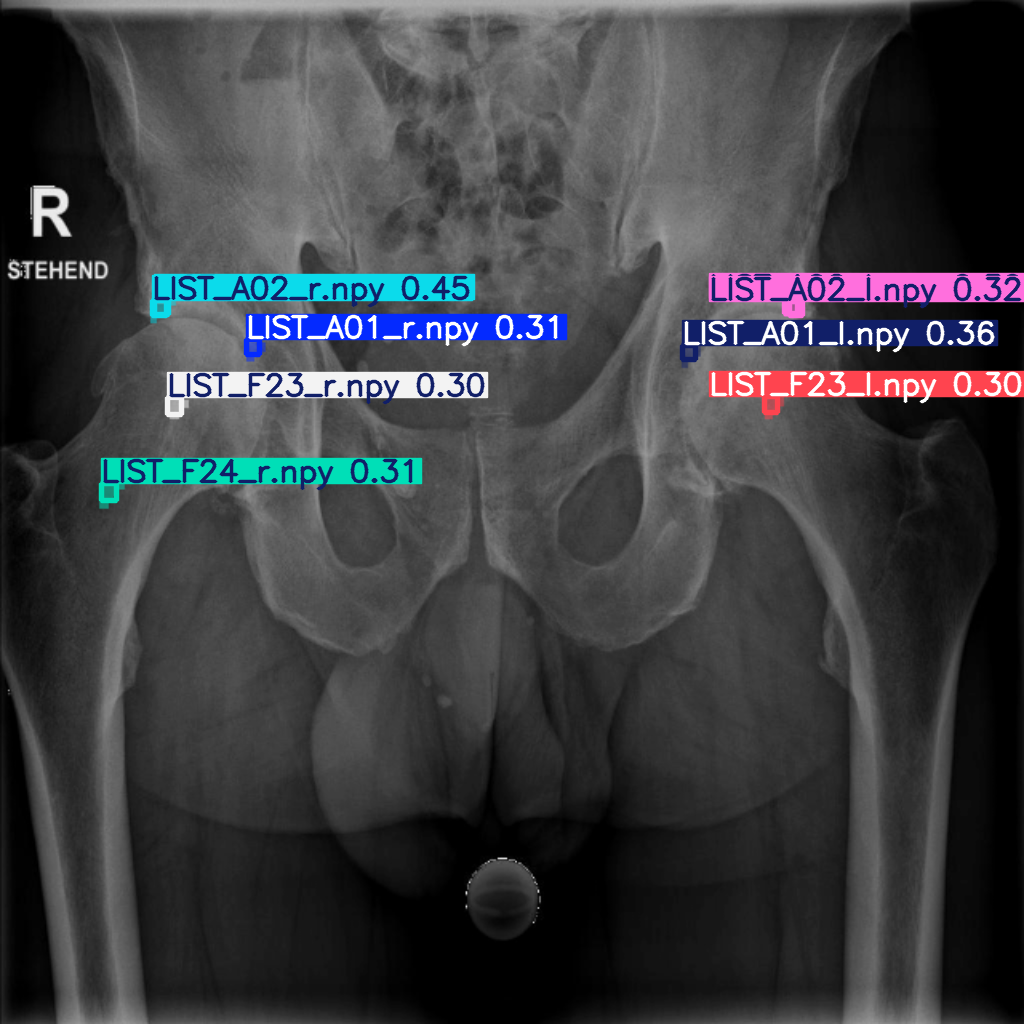

In [69]:
test = images[0]
res = model(f'datasets/yolo_segm_full_8lms/test/images/{test}', project='runs_8_lm_segm_300', name = 'test_one')
res[0].show()